# House Prices - Advanced Regression Techniques
## Predict sales prices and practice feature engineering, RFs, and gradient boosting

# 2. Data Exploration and Preprocessing

## Load and Exploring the dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
df1 = pd.read_csv('data_downloaded/train.csv')

## Handling Missing Values

In [4]:
replacement_dictionary = {
                            'PoolQC'      : 'No Pool',
                            'MiscFeature' : 'No MiscFeatures',  
                            'Alley'       : 'No Alley Access',
                            'Fence'       : 'No Fence',
                            'FireplaceQu' : 'No FirePlace', 
                            'GarageFinish': 'No Garage',
                            'GarageQual'  : 'No Garage',
                            'GarageCond'  : 'No Garage',
                            'GarageType'  : 'No Garage',
                            'BsmtExposure': 'No Basement',
                            'BsmtCond'    : 'No Basement',
                            'BsmtQual'    : 'No Basement',
                            'BsmtFinType2': 'No Basement',
                            'BsmtFinType1': 'No Basement',
                            'Electrical'  : 'No Electrical',
                            'MasVnrType'  : 'No MasVnr',
                            'MasVnrArea'  : 0,
                            'LotFrontage' : 0,
                            'GarageYrBlt' : 0}

In [5]:
from data_downloaded.fatih_missing_values import Dealing_missing_values

In [6]:
missing_handler = Dealing_missing_values(df1)

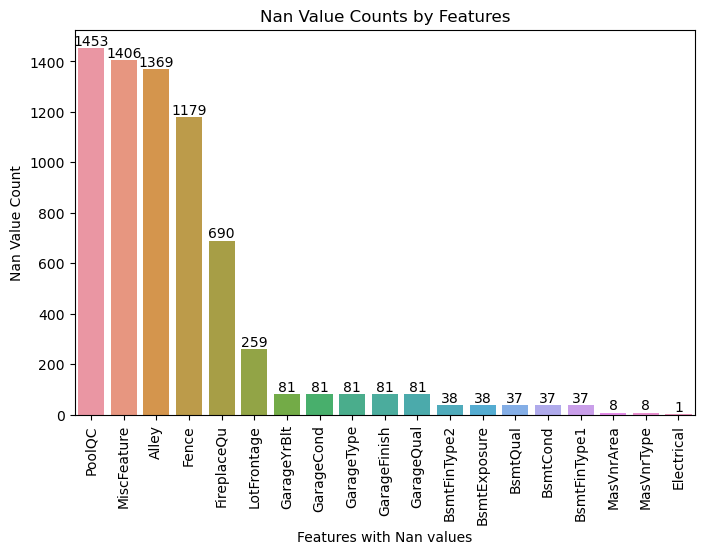

In [7]:
missing_handler.show_missing_values()

In [8]:
missing_handler.replace(replacement_dictionary)

In [9]:
missing_handler.show_missing_values()

There are no missing values


In [10]:
df2 = df1.copy()

In [11]:
df2.shape

(1460, 81)

## Feature Engineering

### Summarizing Features: Creating new Features and drop old ones

In [12]:
# Create 'Total_Area' / drop '1stFlrSF', '2ndFlrSF'
df2['Total_Area_AbvGr'] =  df2['1stFlrSF'] + df2['2ndFlrSF']

# Hold 'TotRmsAbvGrd' / drop 'BedroomAbvGr'

# Create Total Bathrooms / drop 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath'
df2['Total_Bathrooms'] = df2['BsmtFullBath'] + df2['FullBath'] + 0.5*(df2['BsmtHalfBath'] + df2['HalfBath'])

# Create Age of the House / drop 'YearBuilt'
df2['Age_of_Property'] = df2['YearBuilt'].max() - df2['YearBuilt']

# Create 'Age_of_Renovation' / drop 'YearRemodAdd'
df2['Age_of_Renovation'] = df2['YearBuilt'].max() - df2['YearRemodAdd']

# Hold 'GarageArea', create 'Has_Garage' binary / drop 'GarageType','GarageYrBlt','GarageFinish','GarageCars','GarageQual','GarageCond'
df2['HasGarage'] = (df2['GarageType'] != 'No Garage').astype(int)

In [13]:
# Create 'Neibhborhood_MedianP' / drop 'Neighborhood'
neighborhood_median_price = df2.groupby('Neighborhood')['SalePrice'].median().reset_index()
neighborhood_median_price.columns = ['Neighborhood', 'MedianHousePrice']
df2 = pd.merge(df2, neighborhood_median_price, on='Neighborhood', how='left')

In [14]:
# Define different mappings for each basement features (because we will make math operations/grading)
bsmt_qual_mapping = {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'No Basement': 0}
bsmt_cond_mapping = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'No Basement': 0}
bsmt_exposure_mapping = {'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'No Basement': 0}
bsmt_fintype_mapping = {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'No Basement': 0}

# Convert the categorical str values into grade points by mapping function
df2['BsmtFinType1'] = df2['BsmtFinType1'].map(bsmt_fintype_mapping)
df2['BsmtFinType2'] = df2['BsmtFinType2'].map(bsmt_fintype_mapping)
df2['BsmtQual'] = df2['BsmtQual'].map(bsmt_qual_mapping)
df2['BsmtCond'] = df2['BsmtCond'].map(bsmt_cond_mapping)
df2['BsmtExposure'] = df2['BsmtExposure'].map(bsmt_exposure_mapping)

# FinType has a numeric grade and a corresponding sqfoot, combine them
df2['BsmtFinGrade'] = (df2['BsmtFinType1'] * df2.BsmtFinSF1 / df2.TotalBsmtSF) + \
                      (df2['BsmtFinType2'] * df2.BsmtFinSF2 / df2.TotalBsmtSF) + \
                      (df2['BsmtFinType1'] * df2.BsmtUnfSF / df2.TotalBsmtSF)

# Because of zero division there will be Nan values where there are no basement, since TotalBsmtSf == 0
df2['BsmtFinGrade'].fillna(0.0, inplace=True)

# Combine into one single 'BsmtOverallGrade'
df2['BsmtOverallGrade'] = round((df2['BsmtQual'] + df2['BsmtCond'] + df2['BsmtExposure'] + df2['BsmtFinGrade']), 2)

# Drop :
# 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1','BsmtFinType2', 
# 'BsmtFinSF2','BsmtUnfSF','BsmtFinGrade'

In [15]:
# Create 'Terrace_Grade' / drop 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch'
terrace_columns = ['WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch']
terrace_weights = [1, 1, 2, 2, 2]

df2['Terrace_Grade'] = np.dot(df2[terrace_columns], terrace_weights)

__Dropping the columns__

In [16]:
col_drop_feat_eng = ['1stFlrSF', '2ndFlrSF', 
                     'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 
                    'YearBuilt', 'YearRemodAdd', 
                    'GarageType','GarageYrBlt','GarageFinish','GarageCars','GarageQual','GarageCond',
                    'Neighborhood', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1','BsmtFinType2', 
                    'BsmtFinSF2','BsmtUnfSF','BsmtFinGrade',
                    'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch']

In [17]:
df3 = df2.drop(columns=col_drop_feat_eng)
df3.shape

(1460, 61)

In [18]:
df3.sample(2)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,LowQualFinSF,GrLivArea,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageArea,PavedDrive,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Total_Area_AbvGr,Total_Bathrooms,Age_of_Property,Age_of_Renovation,HasGarage,MedianHousePrice,BsmtOverallGrade,Terrace_Grade
1041,1042,60,RL,0.0,9130,Pave,No Alley Access,Reg,Lvl,AllPub,Inside,Gtl,Feedr,Norm,1Fam,2Story,6,8,Hip,CompShg,HdBoard,HdBoard,BrkFace,252.0,TA,TA,CBlock,800,GasA,Gd,Y,SBrkr,0,1632,4,1,Gd,7,Typ,0,No FirePlace,484,Y,0,No Pool,No Fence,No MiscFeatures,0,7,2008,WD,Normal,173000,1632,2.0,44,10,1,182900.0,12.76,40
489,490,180,RM,21.0,1526,Pave,No Alley Access,Reg,Lvl,AllPub,Inside,Gtl,Norm,Norm,Twnhs,SFoyer,4,8,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,Gd,CBlock,630,GasA,TA,Y,SBrkr,0,630,1,1,Gd,3,Typ,0,No FirePlace,286,Y,0,No Pool,No Fence,No MiscFeatures,0,5,2009,WD,Normal,86000,630,2.0,40,8,1,88000.0,16.00,0


### High and Low Cardinality

Cardinality is an issue for categorical variables. But our df has some cat vars in numerical vars as well 

In [19]:
from data_downloaded.fatih_eda import plot_histograms_for_all_numeric

In [23]:
plot_histograms_for_all_numeric(df3)

NameError: name 'self' is not defined

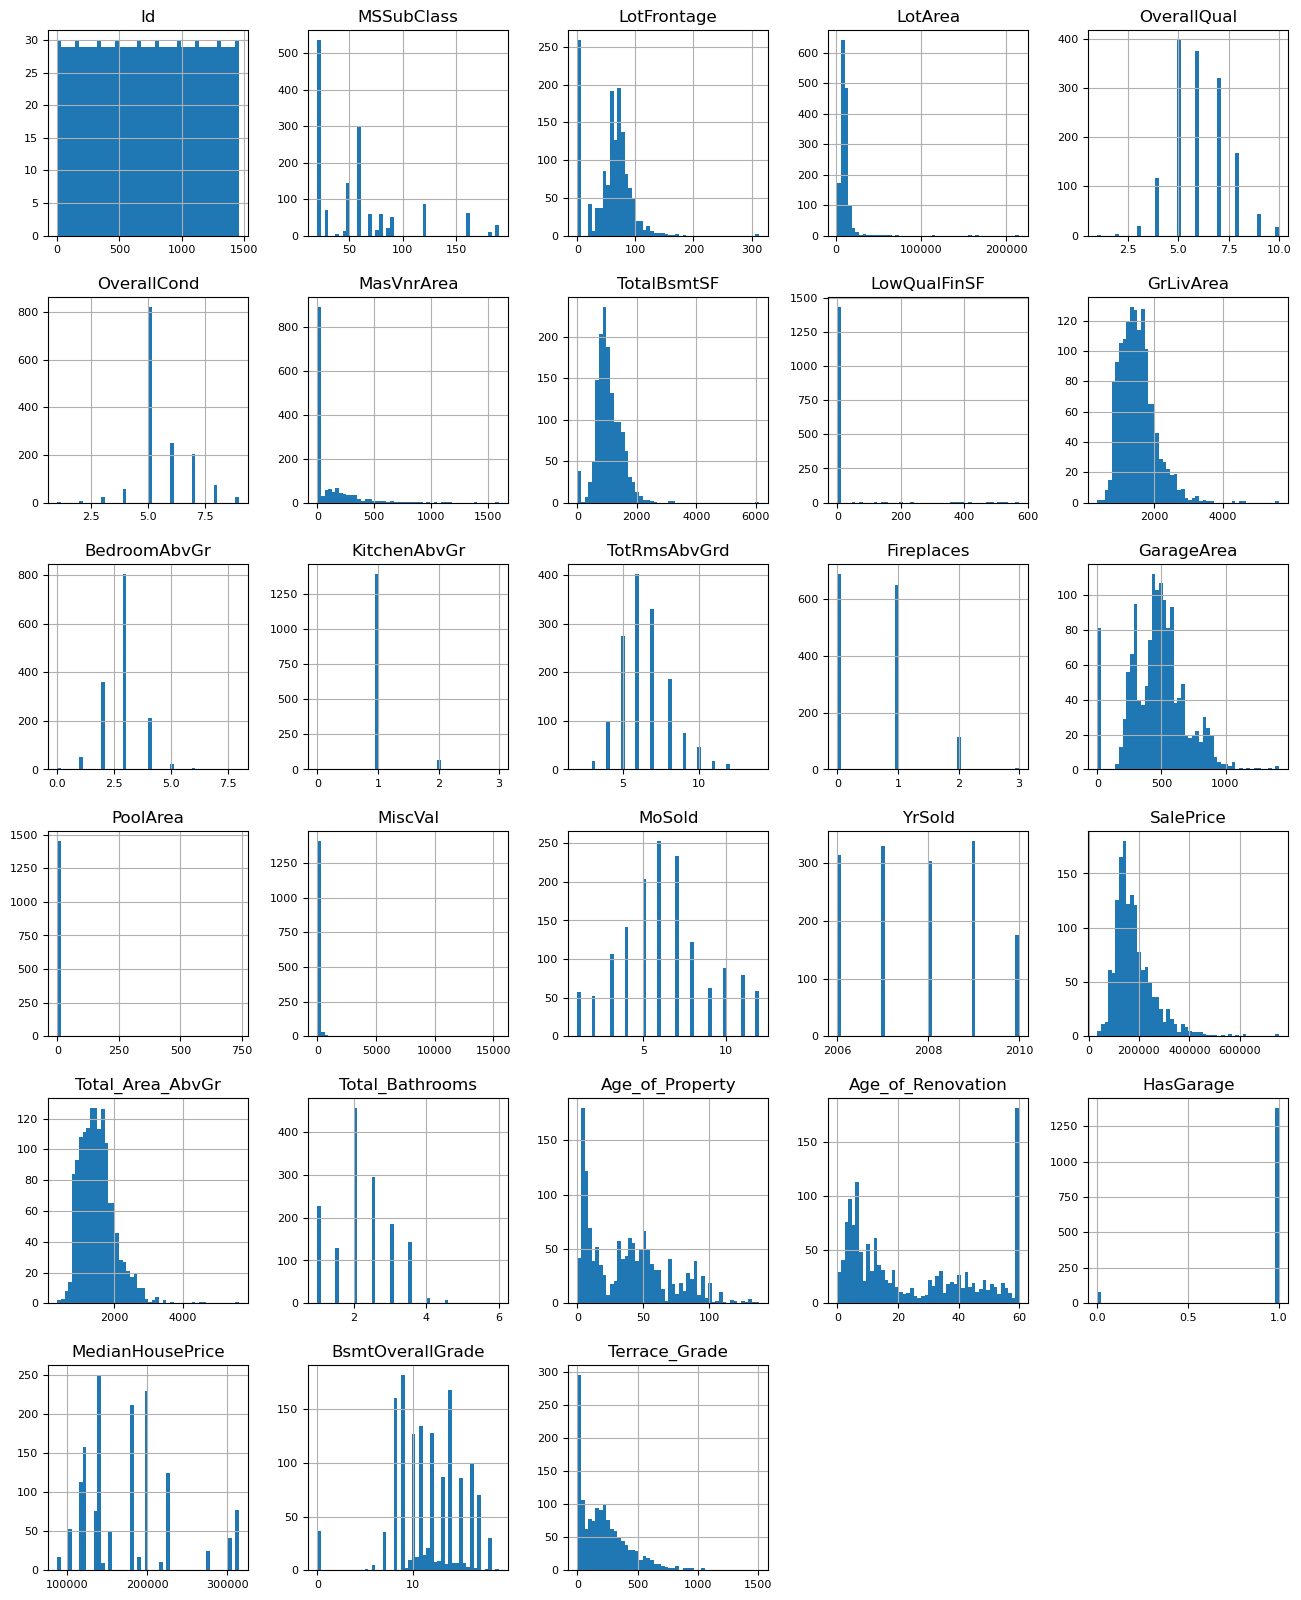

In [128]:
df3.select_dtypes(include='number').hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

In [127]:
df3['KitchenAbvGr'].var()

0.048548921667120055

In [101]:
object_columns = df2.select_dtypes(include='object').columns
n_rows = (len(object_columns) + 1) // 4
n_cols = 4

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 2 * n_rows))

# Flatten the axes if there's only one row
if n_rows == 1:
    axes = axes.reshape(1, -1)

# Loop through each object column and create countplots
for i, col in enumerate(object_columns):
    sns.countplot(x=col, data=df, ax=axes[i//n_cols, i%n_cols])

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

NameError: name 'df5' is not defined

pool columnlar da gidecek

**Firstly**, we need to drop ID column, because it has unique values and results in high cardinality  

In [75]:
df3['Utilities'].value_counts().var()

1062882.0

In [60]:
df5.drop(columns=['Id'], inplace=True)

Lets observe more on categorical features

In [61]:
df5.describe(include='object').T

,count,unique,top,freq
MSZoning,1460,5,RL,1151
Street,1460,2,Pave,1454
Alley,1460,3,No Alley Access,1369
LotShape,1460,4,Reg,925
LandContour,1460,4,Lvl,1311
Utilities,1460,2,AllPub,1459
LotConfig,1460,5,Inside,1052
LandSlope,1460,3,Gtl,1382
Condition1,1460,9,Norm,1260
Condition2,1460,8,Norm,1445


**Secondly,** 'Street', 'Utilities', 'Condition2', 'RoofMatl', 'Heating', 'MiscFeature' columns has too low variations and resulting **Low Cardinalty**  
Therefore i consider to drop them

In [62]:
df6 = df5.drop(columns = ['Street', 'Utilities', 'Condition2', 'RoofMatl', 'Heating', 'MiscFeature'])

In [63]:
df6.shape

(1460, 56)

### Multicollinearity

**Identifying Correlated Features:** Identifying and addressing multicollinearity is crucial for regression models. Dropping one of a set of highly correlated features is a good strategy. It helps to keep the model more interpretable and efficient.  
**VIF (Variance Inflation Factor)**: If you want a more quantitative approach to assess multicollinearity, you can use VIF. A high VIF score indicates a high correlation between a feature and other features in the dataset.

Before diving into mathematical calculations, we can check any variables with our domain knowledge


'GrLivArea', 'TotRmsAbvGrd', 'Total_Area' are strongly correlated each other. I need to find a balance between dropping and holding  
I think Room Number is important along with Total Area  
So i can drop Living Area Above the Ground

In [64]:
df6.drop(columns=['GrLivArea'], inplace=True)

#### Numeric Features: Correlation Matrix

In [65]:
corr_matrix = df6.corr()[(df6.corr().abs() > 0.7) & (df6.corr().abs() != 1)]

# Drop rows and columns with all NaN values
corr_matrix = corr_matrix.dropna(axis=1, how='all').dropna(axis=0, how='all')
corr_matrix

,OverallQual,SalePrice,Total_Area,MedianHousePrice
OverallQual,NaN,0.790982,NaN,NaN
SalePrice,0.790982,NaN,0.78226,0.733515
Total_Area,NaN,0.782260,NaN,NaN
MedianHousePrice,NaN,0.733515,NaN,NaN


I didnt see any issues here

#### Categorical Features: Cramer's V

In [66]:
df6.describe(include='object').T

,count,unique,top,freq
MSZoning,1460,5,RL,1151
Alley,1460,3,No Alley Access,1369
LotShape,1460,4,Reg,925
LandContour,1460,4,Lvl,1311
LotConfig,1460,5,Inside,1052
LandSlope,1460,3,Gtl,1382
Condition1,1460,9,Norm,1260
BldgType,1460,5,1Fam,1220
HouseStyle,1460,8,1Story,726
RoofStyle,1460,6,Gable,1141


**Cramér's V**   
I can investigate with my domain knowledge, but i will try to measure the dependencies with **Cramér's V**

Cramér's V is a suitable measure for associations between categorical variables. It provides a value between 0 and 1, where 0 indicates no association and 1 indicates a perfect association. This metric gives you a good sense of the strength of association between categorical variables.

In [67]:
categorical_variables = list(df6.columns[df6.dtypes == 'object'])
categorical_variables

['MSZoning',
 'Alley',
 'LotShape',
 'LandContour',
 'LotConfig',
 'LandSlope',
 'Condition1',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'PavedDrive',
 'Fence',
 'SaleType',
 'SaleCondition']

In [68]:
from scipy.stats import chi2_contingency

cramer_v_dict = {}

for var1 in categorical_variables:
    for var2 in categorical_variables:
        if var1 != var2:
            contingency_table = pd.crosstab(df6[var1], df6[var2])
            chi2, _, _, _ = chi2_contingency(contingency_table)
            num_obs = contingency_table.sum().sum()
            v = np.sqrt(chi2 / (num_obs * (min(contingency_table.shape) - 1)))
            cramer_v_dict[(var1, var2)] = v

In [69]:
for i, v in cramer_v_dict.items():
    if v>0.4:
        print(i,v)

('LandContour', 'LandSlope') 0.459179613790028
('LandSlope', 'LandContour') 0.459179613790028
('Exterior1st', 'Exterior2nd') 0.7620101123416536
('Exterior2nd', 'Exterior1st') 0.7620101123416535
('ExterQual', 'KitchenQual') 0.5473579787253363
('CentralAir', 'Electrical') 0.4243580948005979
('Electrical', 'CentralAir') 0.4243580948005979
('KitchenQual', 'ExterQual') 0.5473579787253363
('SaleType', 'SaleCondition') 0.475808623503821
('SaleCondition', 'SaleType') 0.4758086235038211


Here is the measures i will take:
- I will drop Landslope over LandContour, because contour has more descriptive data

In [70]:
df6.drop(columns=['LandSlope'], inplace=True)

- I will drop Exterior2nd. Because, except 212 instances there are no value in Exterior 2nd. Even exist, its not as descriptive as it harms model by multicollinearity

In [71]:
df6.drop(columns=['Exterior2nd'], inplace=True)

* I drop electrical over CentralAir since CentralAir is more easy to interpret with its BinaryClass

In [72]:
df6.drop(columns=['Electrical'], inplace=True)

* I will drop ExterQual ove KitchenQual.
* ExterQual somehow is reflected in External material, age, renovation age

In [73]:
df6.drop(columns=['ExterQual'], inplace=True)

* i will drop SaleType over SaleCondition. because it is less descriptive and also it's data is somehow described in other columns as well

In [74]:
df6.drop(columns=['SaleType'], inplace=True)

In [75]:
df7 = df6.copy()
df7.shape

(1460, 50)

### Feature Engineering Continued

In [76]:
df7.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Alley', 'LotShape',
       'LandContour', 'LotConfig', 'Condition1', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'RoofStyle', 'Exterior1st', 'MasVnrType',
       'MasVnrArea', 'ExterCond', 'Foundation', 'HeatingQC', 'CentralAir',
       'LowQualFinSF', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageArea',
       'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'Fence', 'MiscVal', 'MoSold', 'YrSold', 'SaleCondition',
       'SalePrice', 'Total_Area', 'Total_Bathrooms', 'Age_of_Property',
       'Age_of_Renovation', 'HasGarage', 'HasPool', 'MedianHousePrice',
       'BsmtOverallGrade'],
      dtype='object')

**Rooms**

In [77]:
# no need to hold both TotRmsAbvGrd and 'BedroomAbvGr'
df7.drop(columns = ['BedroomAbvGr'], inplace=True)

**Porch and Deck Columns**

'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch'  
i will combine these features into one single one

In [78]:
terrace_columns = ['WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch']
terrace_weights = [1, 1, 2, 2, 2]

df7['Terrace_Grade'] = (df7[terrace_columns[0]] * terrace_weights[0] +
                            df7[terrace_columns[1]] * terrace_weights[1] +
                             df7[terrace_columns[2]] * terrace_weights[2] +
                             df7[terrace_columns[3]] * terrace_weights[3] +
                             df7[terrace_columns[4]] * terrace_weights[4])

In [79]:
df8 = df7.drop(columns=terrace_columns)

## Final Issues Feature Engineering

**this part is the version0.1 of the model with limited features selected by domain knowledge and dataset information**

In [80]:
df8.shape

(1460, 45)

For the sake of simplicity i will only select some of the features for the first run of model  
Later on, i will come to this part and continue with 46 features again. And make a comparison

In [81]:
df8.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Alley', 'LotShape',
       'LandContour', 'LotConfig', 'Condition1', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'RoofStyle', 'Exterior1st', 'MasVnrType',
       'MasVnrArea', 'ExterCond', 'Foundation', 'HeatingQC', 'CentralAir',
       'LowQualFinSF', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageArea', 'PavedDrive',
       'Fence', 'MiscVal', 'MoSold', 'YrSold', 'SaleCondition', 'SalePrice',
       'Total_Area', 'Total_Bathrooms', 'Age_of_Property', 'Age_of_Renovation',
       'HasGarage', 'HasPool', 'MedianHousePrice', 'BsmtOverallGrade',
       'Terrace_Grade'],
      dtype='object')

I will use domain knowledge and intuition from the dataset i gathered, and will drop more features. I want to have around 15-20 features to continue our model

In [82]:
columns_to_use_v1 = ['BsmtOverallGrade', 'Terrace_Grade', 'ExterCond', 'KitchenQual', 'OverallQual', 'OverallCond','LotArea', 
                     'Total_Area', 'Total_Bathrooms', 'GarageArea', 'TotRmsAbvGrd','Age_of_Property', 'Age_of_Renovation', 
                     'MoSold', 'YrSold', 'SaleCondition','MSZoning', 'MedianHousePrice', 'SalePrice', 'Condition1', 'HouseStyle']

In [83]:
df9 = df8[columns_to_use_v1]
df9.shape

(1460, 21)

In [84]:
df9.sample(3)

,BsmtOverallGrade,Terrace_Grade,ExterCond,KitchenQual,OverallQual,OverallCond,LotArea,Total_Area,Total_Bathrooms,GarageArea,...,Age_of_Property,Age_of_Renovation,MoSold,YrSold,SaleCondition,MSZoning,MedianHousePrice,SalePrice,Condition1,HouseStyle
660,9.000000,617,TA,TA,7,7,12384,2728,2.5,550,...,34,34,11,2007,Normal,RL,182900.0,197900,Norm,2Story
643,10.367949,208,TA,TA,5,5,10793,2400,2.5,462,...,41,41,4,2007,Normal,RL,182900.0,152000,RRAn,2Story
368,9.000000,98,TA,TA,5,6,7800,2536,1.0,244,...,56,56,3,2010,Normal,RL,140000.0,132000,Norm,1Story


## Outliers

In [70]:
from data_downloaded.outliers import FatihOutliers

In [72]:
outliers = FatihOutliers(df9)

NameError: name 'df9' is not defined

In [87]:
outliers_df = outliers.detect_outlier_rows()
print(f"There are total {len(outliers_df)} outliers out of {len(df9)} data")

There are total 52 outliers out of 1460 data


In [88]:
outlier_columns = outliers.detect_outlier_columns()
print(outlier_columns)

['Terrace_Grade', 'LotArea', 'Total_Area', 'Total_Bathrooms', 'GarageArea', 'TotRmsAbvGrd', 'SalePrice']


__Too much outliers__  
Lets try to analyze them

In [89]:
outliers.outlier_stats()

,Feature,Negative Outliers,Positive Outliers
0,Terrace_Grade,0,1
1,LotArea,0,34
2,Total_Area,0,5
3,Total_Bathrooms,0,9
4,GarageArea,0,3
5,TotRmsAbvGrd,0,1
6,SalePrice,0,12


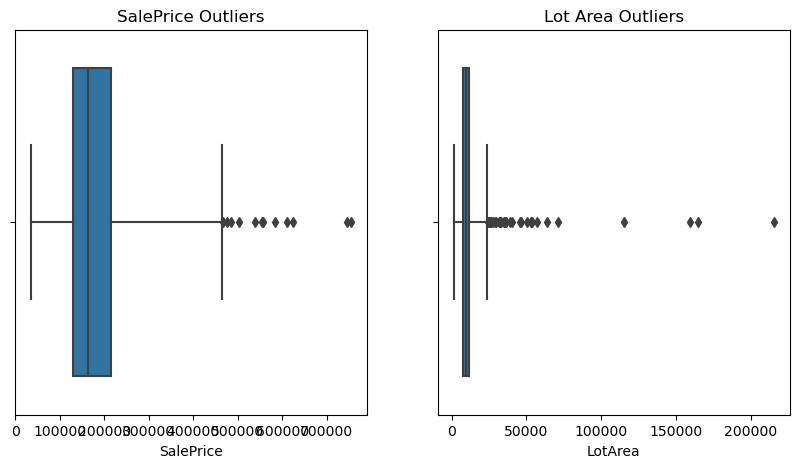

In [90]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.boxplot(df9['SalePrice']   ,ax=ax1, whis=3)
ax1.set_title('SalePrice Outliers')

sns.boxplot(df9['LotArea']  ,ax=ax2, whis=3)
ax2.set_title('Lot Area Outliers')

plt.show()

I think We can drop these 51 outliers

In [91]:
df10 = df9.drop(axis=0, index=outliers_df.index)
df10.shape

(1408, 21)

## Log Transformation of SalePrice

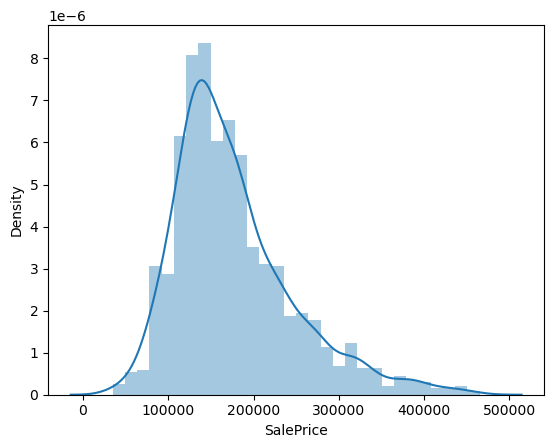

In [92]:
sns.distplot(df10['SalePrice']);

In [93]:
df10['SalePrice'].skew()

1.1580690677521988

Our SalePrices are slightly positive (right) skewed so we may consider to make a log transformation.  
but since skewness is low, thanks to removing the outliers, i will go on without log transformation for this V1 model

## Encode categorical variables

### Nominal Categories

In [94]:
df10.dtypes

BsmtOverallGrade     float64
Terrace_Grade          int64
ExterCond             object
KitchenQual           object
OverallQual            int64
OverallCond            int64
LotArea                int64
Total_Area             int64
Total_Bathrooms      float64
GarageArea             int64
TotRmsAbvGrd           int64
Age_of_Property        int64
Age_of_Renovation      int64
MoSold                 int64
YrSold                 int64
SaleCondition         object
MSZoning              object
MedianHousePrice     float64
SalePrice              int64
Condition1            object
HouseStyle            object
dtype: object

In [95]:
nominal_categories = ['MSZoning', 'Condition1', 'HouseStyle', 'SaleCondition']

In [96]:
df_encoded = pd.get_dummies(df10[nominal_categories], columns=nominal_categories)

In [97]:
df10.drop(columns=nominal_categories, inplace=True)

In [98]:
df11 = pd.concat([df10, df_encoded], axis=1)

In [99]:
df11.shape

(1408, 45)

### Ordinal Categories

In [100]:
ordinal_categories = ['ExterCond',	'KitchenQual']

In [101]:
ordinal_mapping = {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1}

In [102]:
df11['ExterCond'] = df11['ExterCond'].map(ordinal_mapping)

In [103]:
df11['KitchenQual'] = df11['KitchenQual'].map(ordinal_mapping)

In [104]:
df11.sample(3)

,BsmtOverallGrade,Terrace_Grade,ExterCond,KitchenQual,OverallQual,OverallCond,LotArea,Total_Area,Total_Bathrooms,GarageArea,...,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
684,9.0,81,3,3,7,5,16770,3034,2.5,486,...,0,1,0,0,0,0,0,0,1,0
359,16.0,1031,3,4,8,5,12011,3010,3.5,592,...,0,1,0,0,0,0,0,0,1,0
982,11.0,116,3,4,7,5,3182,2532,2.0,388,...,0,0,0,0,0,0,0,0,1,0


In [11]:
#denme

__V2: log transformation here__

In [105]:
y = np.log(df11['SalePrice'])
df12 = df11.drop(columns=['SalePrice', 'HouseStyle_2.5Fin'])

In [106]:
X=df12.copy()

In [107]:
X.head()

,BsmtOverallGrade,Terrace_Grade,ExterCond,KitchenQual,OverallQual,OverallCond,LotArea,Total_Area,Total_Bathrooms,GarageArea,...,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,14.0,61,3,4,7,5,8450,2566,3.5,548,...,0,1,0,0,0,0,0,0,1,0
1,16.0,298,3,3,6,8,9600,2524,2.5,460,...,0,0,0,0,0,0,0,0,1,0
2,15.0,42,3,4,7,5,11250,2706,3.5,608,...,0,1,0,0,0,0,0,0,1,0
3,13.0,579,3,4,7,5,9550,2473,2.0,642,...,0,1,0,0,1,0,0,0,0,0
4,16.0,276,3,4,8,5,14260,3343,3.5,836,...,0,1,0,0,0,0,0,0,1,0


# Prepare Test Data

In [108]:
df_test = pd.read_csv('data_downloaded/test.csv')
df_test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [109]:
missing_handler_test = Dealing_missing_values(df_test)

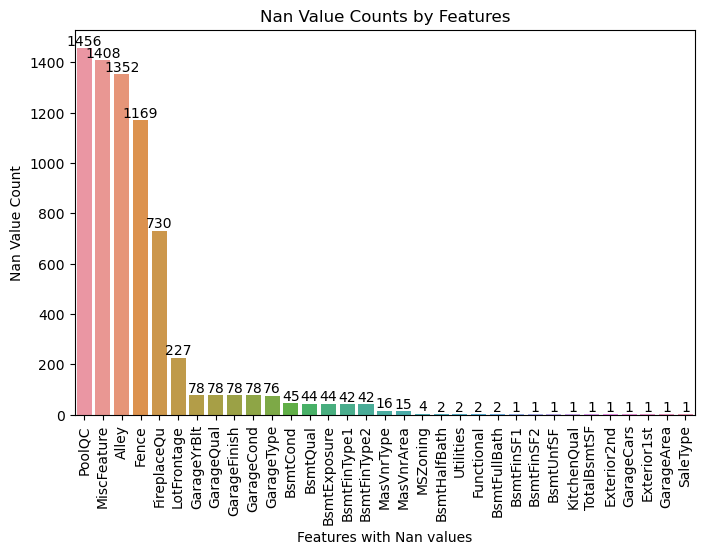

In [110]:
missing_handler_test.show_missing_values()

In [111]:
missing_handler_test.replace(replacement_dictionary)

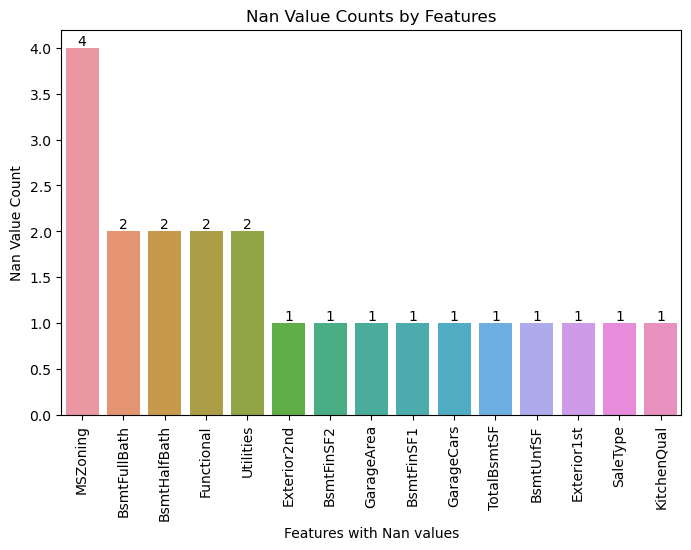

In [112]:
missing_handler_test.show_missing_values()

In [113]:
missing_handler_test.mmm(['MSZoning', 'Functional', 'Utilities', 'Exterior2nd', 'Exterior1st', 'SaleType', 'KitchenQual'], 'mode')

In [114]:
replacement_dictionary_test = {'BsmtFullBath':0, 'BsmtHalfBath':0, 'BsmtFinSF2':0, 'GarageArea':0, 'BsmtFinSF1':0, 'GarageCars':0, 'TotalBsmtSF':0,
        'BsmtUnfSF':0}

In [115]:
missing_handler_test.replace(replacement_dictionary_test)

In [116]:
missing_handler_test.show_missing_values()

There are no missing values


In [117]:
df_test['Total_Area'] = df_test['TotalBsmtSF'] + df_test['1stFlrSF'] + df_test['2ndFlrSF']

In [118]:
df_test['Total_Bathrooms'] = df_test['BsmtFullBath'] + df_test['FullBath'] + 0.5*(df_test['BsmtHalfBath'] + df_test['HalfBath'])

In [119]:
newest_blt = df_test['YearBuilt'].max()
df_test['Age_of_Property'] = newest_blt - df_test['YearBuilt']

In [120]:
df_test['Age_of_Renovation'] = newest_blt - df_test['YearRemodAdd']

In [121]:
df_test['HasGarage'] = (df_test['GarageType'] != 'No Garage').astype(int)

In [122]:
df_test['HasPool'] = (df_test['PoolQC'] != 'No Pool').astype(int)

In [123]:
df_test = pd.merge(df_test, neighborhood_median_price, on='Neighborhood', how='left')
df_test.sample(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,YrSold,SaleType,SaleCondition,Total_Area,Total_Bathrooms,Age_of_Property,Age_of_Renovation,HasGarage,HasPool,MedianHousePrice
876,2337,20,RL,75.0,9910,Pave,No Alley Access,Reg,Lvl,AllPub,...,2007,New,Partial,2738.0,2.0,3,3,1,0,225500.0
1139,2600,20,RL,200.0,43500,Pave,No Alley Access,Reg,Lvl,AllPub,...,2007,WD,Normal,2034.0,1.0,57,57,1,0,153500.0
1007,2468,45,RM,40.0,5680,Pave,Grvl,Reg,Lvl,AllPub,...,2007,WD,AdjLand,1765.0,2.0,109,60,1,0,119000.0
272,1733,20,RL,0.0,9079,Pave,No Alley Access,IR1,Lvl,AllPub,...,2009,WD,Normal,1728.0,1.0,49,49,1,0,135000.0
1256,2717,60,FV,114.0,8314,Pave,Pave,IR1,Lvl,AllPub,...,2006,WD,Normal,2263.0,2.5,13,12,1,0,225500.0


In [124]:
df_test['BsmtFinType1'] = df_test['BsmtFinType1'].map(bsmt_fintype_mapping)
df_test['BsmtFinType2'] = df_test['BsmtFinType2'].map(bsmt_fintype_mapping)

In [125]:
df_test['BsmtFinGrade'] = (df_test['BsmtFinType1'] * df_test.BsmtFinSF1 / df_test.TotalBsmtSF) + \
                            (df_test['BsmtFinType2'] * df_test.BsmtFinSF2 / df_test.TotalBsmtSF) + \
                            (df_test['BsmtFinType1'] * df_test.BsmtUnfSF / df_test.TotalBsmtSF)

In [126]:
df_test['BsmtFinGrade'].fillna(0.0, inplace=True)

In [127]:
df_test['BsmtQual'] = df_test['BsmtQual'].map(bsmt_qual_mapping)
df_test['BsmtCond'] = df_test['BsmtCond'].map(bsmt_cond_mapping)
df_test['BsmtExposure'] = df_test['BsmtExposure'].map(bsmt_exposure_mapping)

In [128]:
df_test['BsmtOverallGrade'] = df_test['BsmtQual'] + df_test['BsmtCond'] + df_test['BsmtExposure'] + df_test['BsmtFinGrade']

In [129]:
terrace_columns = ['WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch']
terrace_weights = [1, 1, 2, 2, 2]

df_test['Terrace_Grade'] = (df_test[terrace_columns[0]] * terrace_weights[0] +
                            df_test[terrace_columns[1]] * terrace_weights[1] +
                             df_test[terrace_columns[2]] * terrace_weights[2] +
                             df_test[terrace_columns[3]] * terrace_weights[3] +
                             df_test[terrace_columns[4]] * terrace_weights[4])

In [130]:
columns_to_use_v1_test = ['BsmtOverallGrade', 'Terrace_Grade', 'ExterCond', 'KitchenQual', 'OverallQual', 'OverallCond','LotArea', 
                     'Total_Area', 'Total_Bathrooms', 'GarageArea', 'TotRmsAbvGrd','Age_of_Property', 'Age_of_Renovation', 
                     'MoSold', 'YrSold', 'SaleCondition','MSZoning', 'MedianHousePrice', 'Condition1', 'HouseStyle']

In [131]:
df_test_2 = df_test[columns_to_use_v1_test]

In [132]:
df_encoded_test = pd.get_dummies(df_test_2[nominal_categories], columns=nominal_categories)

In [133]:
df_test_2.drop(columns=nominal_categories, inplace=True)

In [134]:
df_test_3 = pd.concat([df_test_2, df_encoded_test], axis=1)

In [135]:
df_test_3['ExterCond'] = df_test_3['ExterCond'].map(ordinal_mapping)

In [136]:
df_test_3['KitchenQual'] = df_test_3['KitchenQual'].map(ordinal_mapping)

In [137]:
set(df_test_3.columns) == set(X.columns)

True

In [166]:
X_test_gercek = df_test_3.copy()

In [167]:
X_test_gercek.shape

(1459, 43)

In [168]:
print(f"X Shape is :{X.shape}")
print(f"y Shape is :{y.shape}")
print(f"X_test_gercek Shape is :{X_test_gercek.shape}")

X Shape is :(1408, 43)
y Shape is :(1408,)
X_test_gercek Shape is :(1459, 43)


# Linear Regression

In [163]:
from sklearn.model_selection import train_test_split

In [544]:
print(y.shape)
print(X.shape)

(1408,)
(1408, 43)


In [545]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [546]:
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))

1126
1126
282
282


In [149]:
from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

In [548]:
# Lets instantiate the model
model = LinearRegression()

In [549]:
# Lets train the model
model.fit(X_train, y_train)

LinearRegression()

## Cross Validation

In [550]:
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
rmse_scores = np.sqrt(-cv_scores)

In [551]:
print(f'Cross-Validation RMSE Scores: {rmse_scores}')
print(f'Mean RMSE: {rmse_scores.mean()}')

Cross-Validation RMSE Scores: [0.12536683 0.13128444 0.10536382 0.10931124 0.12065442]
Mean RMSE: 0.11839614955267148


## Make Predictions

In [584]:
y_pred = model.predict(X_test)

In [585]:
y_pred

array([11.67890568, 12.01330201, 12.04162164, ..., 12.04109768,
       11.7212861 , 12.23327804])

In [586]:
predicted_prices = np.exp(y_pred)
predicted_prices

array([118054.97468923, 164934.22025757, 169671.86482776, ...,
       169582.98646572, 123165.72636614, 205515.76859394])

In [162]:
len(predicted_prices)

NameError: name 'predicted_prices' is not defined

# XGBOoost 

In [150]:
import xgboost as xgb

In [165]:
y.shape

(1408,)

In [151]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [161]:
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))

1126
1126
282
282


In [152]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                          max_depth = 5, alpha = 10, n_estimators = 10)
xg_reg.fit(X_train, y_train)

XGBRegressor(alpha=10, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.3, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=10, n_jobs=None,
             num_parallel_tree=None, ...)

In [153]:
y_pred = xg_reg.predict(X_test)

In [154]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", rmse)


RMSE: 0.2597749166152658


In [155]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

# Define the hyperparameters and their ranges to search
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 2, 3]
}

# Create an instance of the XGBoost Regressor
xgb = XGBRegressor()

# Create a GridSearchCV object
grid_search = GridSearchCV(xgb, param_grid, scoring='neg_mean_squared_error', cv=5, verbose=1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 4, 5], 'min_child_weight': [1, 2, 3],
                         'n_estimators': [100, 200, 300]},
             scoring='neg_mean_squared_error', verbose=1)

In [156]:
grid_search.best_params_

{'learning_rate': 0.1,
 'max_depth': 3,
 'min_child_weight': 2,
 'n_estimators': 200}

In [172]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

In [173]:
len(y_pred)

282

In [175]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'Root Mean Squared Error: {rmse}')

Root Mean Squared Error: 0.12325260237383662


__Predict Real Values__

In [179]:
y_pred_xgb = best_model.predict(X_test_gercek)

In [180]:
predicted_prices_xgb = np.exp(y_pred_xgb)
len(predicted_prices_xgb)

1459

# 9. Submitting to Kaggle

In [587]:
df_submit1 = pd.DataFrame({'Id': df_test['Id'], 'SalePrice': predicted_prices})
df_submit1

,Id,SalePrice
0,1461,118054.974689
1,1462,164934.220258
2,1463,169671.864828
3,1464,192684.514740
4,1465,197130.013402
...,...,...
1454,2915,95240.676151
1455,2916,84662.208760
1456,2917,169582.986466
1457,2918,123165.726366


In [181]:
df_submit2 = pd.DataFrame({'Id': df_test['Id'], 'SalePrice': predicted_prices_xgb})
df_submit2

,Id,SalePrice
0,1461,123850.984375
1,1462,173231.578125
2,1463,179380.281250
3,1464,202371.640625
4,1465,177925.437500
...,...,...
1454,2915,91093.210938
1455,2916,84497.453125
1456,2917,163244.609375
1457,2918,124470.242188


In [588]:
#df_submit1.to_csv('data_downloaded/fatih_real_estate_subm01.csv', index=False)

In [182]:
df_submit2.to_csv('data_downloaded/fatih_real_estate_subm02_xgb.csv', index=False)